In [21]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, GlobalAveragePooling2D)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, roc_curve, auc, precision_score, recall_score)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Define paths
TRAIN_DIR_FAST = '../Data/processed/dataset2_processed/train/'
VALIDATION_DIR_FAST = '../Data/processed/dataset2_processed/test/'

TRAIN_DIR_ACCURATE = '../Data/processed/dataset1/train/'
VALIDATION_DIR_ACCURATE = '../Data/processed/dataset1/test/'

MODELS_DIR = '../models/'
os.makedirs(MODELS_DIR, exist_ok=True)

OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/'
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)

OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/'
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)

def fast_model():
    # Fast Model - Binary Classification
    print("Training Fast Model...")

    # Data generators for Fast Model
    train_datagen_fast = ImageDataGenerator(
        rescale=1./255, horizontal_flip=True, zoom_range=0.2)
    validation_datagen_fast = ImageDataGenerator(rescale=1./255)

    train_generator_fast = train_datagen_fast.flow_from_directory(
        TRAIN_DIR_FAST, target_size=(224, 224), batch_size=32, class_mode='binary')

    validation_generator_fast = validation_datagen_fast.flow_from_directory(
        VALIDATION_DIR_FAST, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

    # Define Fast Model architecture
    model_fast = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model_fast.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping_fast = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_fast = ModelCheckpoint(
        '../models/model_fast.h5', save_best_only=True)

    # Train Fast Model
    history_fast = model_fast.fit(
        train_generator_fast,
        epochs=30,
        validation_data=validation_generator_fast,
        callbacks=[early_stopping_fast, checkpoint_fast]
    )

    # Evaluate Fast Model
    print("Evaluating Fast Model...")
    # Get true labels and predictions
    validation_generator_fast.reset()  # Reset the generator
    Y_true = validation_generator_fast.classes
    Y_pred_prob = model_fast.predict(validation_generator_fast, verbose=1)
    Y_pred = (Y_pred_prob > 0.5).astype('int32').reshape(-1)

    # Calculate evaluation accuracy
    evaluation_metrics = model_fast.evaluate(validation_generator_fast, verbose=1)
    evaluation_loss = evaluation_metrics[0]
    evaluation_accuracy = evaluation_metrics[1]
    print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")

    # Calculate F1 Score, Precision, Recall
    f1 = f1_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Classification Report
    target_names = list(validation_generator_fast.class_indices.keys())
    print("Classification Report:")
    print(classification_report(Y_true, Y_pred, target_names=target_names))

    # Confusion Matrix with Percentages
    cm = confusion_matrix(Y_true, Y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percentage = np.nan_to_num(cm_percentage)  # Replace NaN with zero

    plt.figure(figsize=(6,4))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f%', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Percentage) - Fast Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Save confusion matrix
    confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'fast_model_confusion_matrix_percentage.png')
    plt.savefig(confusion_matrix_path)
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Fast Model')
    plt.legend(loc='lower right')
    # Save ROC curve
    roc_curve_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'fast_model_roc_curve.png')
    plt.savefig(roc_curve_path)
    plt.show()

    # Save evaluation metrics to CSV
    metrics_data = {
        'Metric': ['Validation Accuracy', 'Validation Loss', 'F1 Score', 'Precision', 'Recall', 'AUC'],
        'Value': [evaluation_accuracy, evaluation_loss, f1, precision, recall, roc_auc]
    }
    metrics_df = pd.DataFrame(metrics_data)
    metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'fast_model_metrics.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)

    # Save the model (if not already saved by the checkpoint)
    model_fast.save('../models/model_fast_final.h5')

def accurate_model():
    print("Training Accurate Model...")

    # Data generators for Accurate Model
    train_datagen_accurate = ImageDataGenerator(
        rescale=1./255, horizontal_flip=True, rotation_range=20)
    
    validation_datagen_accurate = ImageDataGenerator(rescale=1./255)

    train_generator_accurate = train_datagen_accurate.flow_from_directory(
        TRAIN_DIR_ACCURATE, target_size=(224, 224), batch_size=32, class_mode='categorical')

    validation_generator_accurate = validation_datagen_accurate.flow_from_directory(
        VALIDATION_DIR_ACCURATE, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

    # Define Accurate Model architecture using ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model_accurate = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')  # 8 emotion classes
    ])

    model_accurate.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping_accurate = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_accurate = ModelCheckpoint(
        '../models/model_accurate.h5', save_best_only=True)

    # Train Accurate Model
    history_accurate = model_accurate.fit(
        train_generator_accurate,
        epochs=1,
        validation_data=validation_generator_accurate,
        callbacks=[early_stopping_accurate, checkpoint_accurate]
    )

    # Evaluate Accurate Model
    print("Evaluating Accurate Model...")
    # Get true labels and predictions
    validation_generator_accurate.reset()
    Y_true = validation_generator_accurate.classes
    Y_pred_prob = model_accurate.predict(validation_generator_accurate, verbose=1)
    Y_pred = np.argmax(Y_pred_prob, axis=1)

    # Calculate evaluation accuracy
    evaluation_metrics = model_accurate.evaluate(validation_generator_accurate, verbose=1)
    evaluation_loss = evaluation_metrics[0]
    evaluation_accuracy = evaluation_metrics[1]
    print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")

    # Calculate F1 Score, Precision, Recall
    f1 = f1_score(Y_true, Y_pred, average='weighted')
    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")

    # Classification Report
    target_names = list(validation_generator_accurate.class_indices.keys())
    print("Classification Report:")
    print(classification_report(Y_true, Y_pred, target_names=target_names))

    # Confusion Matrix with Percentages
    cm = confusion_matrix(Y_true, Y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percentage = np.nan_to_num(cm_percentage)  # Replace NaN with zero

    plt.figure(figsize=(10,8))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Percentage) - Accurate Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Save confusion matrix
    confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'accurate_model_confusion_matrix_percentage.png')
    plt.savefig(confusion_matrix_path)
    plt.show()

    # Note on ROC Curve for Multiclass:
    # ROC curves for multiclass classification require a One-vs-Rest approach.
    # Implementing this is more complex and may not be necessary for this context.

    # Save evaluation metrics to CSV
    metrics_data = {
        'Metric': ['Validation Accuracy', 'Validation Loss', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
        'Value': [evaluation_accuracy, evaluation_loss, f1, precision, recall]
    }
    metrics_df = pd.DataFrame(metrics_data)
    metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'accurate_model_metrics.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)

    # Save the model (if not already saved by the checkpoint)
    model_accurate.save('../models/model_accurate_final.h5')

Training Fast Model...
Found 336 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Epoch 1/30
11/11 [==============================] - 10s 1s/step - loss: 3.2920 - accuracy: 0.4464 - val_loss: 0.6938 - val_accuracy: 0.5263
Epoch 2/30
11/11 [==============================] - 11s 1s/step - loss: 0.6854 - accuracy: 0.5863 - val_loss: 0.6656 - val_accuracy: 0.5702
Epoch 3/30
11/11 [==============================] - 9s 748ms/step - loss: 0.6127 - accuracy: 0.6429 - val_loss: 0.5787 - val_accuracy: 0.7105
Epoch 4/30
11/11 [==============================] - 9s 781ms/step - loss: 0.6132 - accuracy: 0.7292 - val_loss: 0.5790 - val_accuracy: 0.6754
Epoch 5/30
11/11 [==============================] - 11s 1s/step - loss: 0.5491 - accuracy: 0.7381 - val_loss: 0.5345 - val_accuracy: 0.7632
Epoch 6/30
11/11 [==============================] - 9s 761ms/step - loss: 0.4945 - accuracy: 0.8006 - val_loss: 0.6088 - val_accuracy: 0.7456
Epoch 7/30
11/11 [==============================]

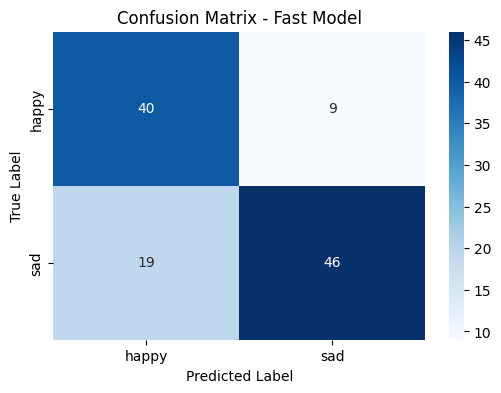

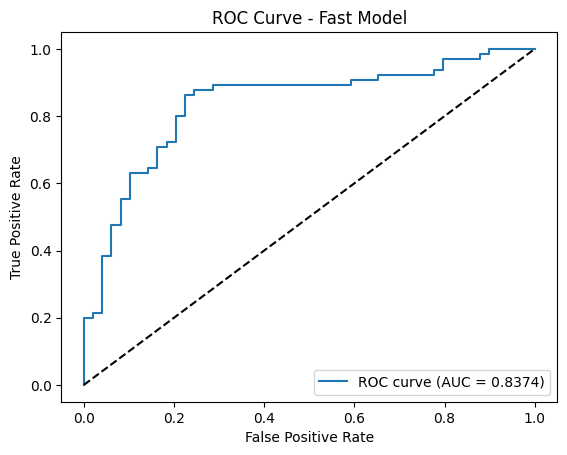

In [9]:
fast_model()

Training Accurate Model...
Found 23229 images belonging to 8 classes.
Found 5813 images belonging to 8 classes.
726/726 [==============================] - 305s 417ms/step - loss: 2.0615 - accuracy: 0.1761 - val_loss: 2.0444 - val_accuracy: 0.1767
Evaluating Accurate Model...
182/182 [==============================] - 36s 196ms/step - loss: 2.0444 - accuracy: 0.1767
Validation Accuracy: 17.67%
Weighted F1 Score: 0.0924
Weighted Precision: 0.0626
Weighted Recall: 0.1767
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       644
    contempt       0.00      0.00      0.00       575
     disgust       0.00      0.00      0.00       496
        fear       0.00      0.00      0.00       636
       happy       0.24      0.67      0.36      1009
     neutral       0.12      0.34      0.17      1026
         sad       0.00      0.00      0.00       619
    surprise       0.00      0.00      0.00       808

    accuracy    

/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

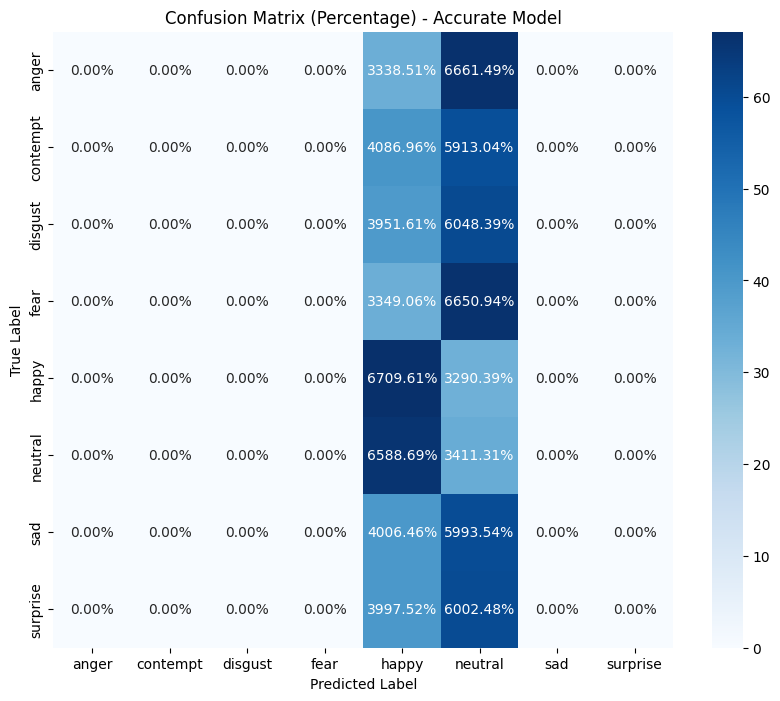

In [22]:
accurate_model()